In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
PROJ_PATH = '/content/drive/My Drive/yolo-v4-tf.keras'
PROJ_PATH = '.'
import sys
sys.path.append(PROJ_PATH)

In [62]:
import cv2
from glob import glob
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
import math
import os
from models import Yolov4, yolov4_head, get_boxes, nms
from config import yolo_config
from loss import *
print(tf.__version__)

2.2.0


In [6]:
with open(os.path.join(PROJ_PATH, 'dataset/train_txt/anno2.txt')) as f:
    lines = f.readlines()
lines = lines[:]
val_lines = lines[:16]
print(lines)

NUM_CLASS = 3
BS = 8
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))

data_gen = DataGenerator(lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=PROJ_PATH, anchors=anchors)
data_gen_val = DataGenerator(val_lines[:], BS, (416, 416), num_classes=NUM_CLASS, folder_path=PROJ_PATH, anchors=anchors)

model = Yolov4(
                weight_path=None,
                class_name_path=os.path.join(PROJ_PATH, 'bccd_classes.txt')
              )
model.build_model(load_pretrained=False)

print('num class : ', model.num_classes)

['dataset/train_img/BloodImage_00000.jpg 260,177,491,376,0 78,336,184,435,2 63,237,169,336,2 214,362,320,461,2 414,352,506,445,2 555,356,640,455,2 469,412,567,480,2 1,333,87,437,2 4,406,95,480,2 155,74,247,174,2 11,84,104,162,2 534,39,639,139,2 547,195,640,295,2 388,11,481,111,2 171,175,264,275,2 260,1,374,83,2 229,91,343,174,2 69,144,184,235,2 482,131,594,230,2 368,89,464,176,2\n', 'dataset/train_img/BloodImage_00001.jpg 68,315,286,480,0 346,361,446,454,2 53,179,146,299,2 449,400,536,480,2 461,132,548,212,2 454,295,541,375,2 417,283,508,383,2 278,342,369,451,2 545,62,636,159,2 485,91,576,188,2 376,171,438,253,2 329,177,395,271,2 291,59,407,168,2 299,1,404,68,2 346,26,449,138,2 134,1,241,95,2 1,38,98,164,2 165,160,257,264,2 464,209,566,319,2\n', 'dataset/train_img/BloodImage_00002.jpg 385,98,523,198,2 384,164,499,260,2 101,120,224,222,2 130,344,234,443,2 161,381,254,480,2 14,228,123,344,2 306,293,415,409,2 531,103,632,221,2 492,233,593,347,2 364,261,465,375,2 264,60,365,174,2 249,174,3

nms iou: 0.413 score: 0.3
num class :  3


In [7]:
model.yolo_model.load_weights(os.path.join(PROJ_PATH, 'bccd.h5'), by_name=True)

In [ ]:
# model.predict('/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img2/test3.jpg')

In [16]:
# i = np.random.randint(0, 300)
# path = f'/content/drive/My Drive/yolo-v4-tf.keras/dataset/train_img/BloodImage_00000.jpg'
# print(path)
# model.predict(path)

In [ ]:
# eye 86 274 146 305
# eye 214 273 282 303
# nose 138 334 220 385
# mouth 139 404 220 437
model.class_names

['WBC', 'Platelets', 'RBC']

#### Generate GT .txt
eye 86 274 146 305

mouth 139 404 220 437

In [9]:
GT_PATH = os.path.join(PROJ_PATH, 'eval/ground_truth')
with open(os.path.join(PROJ_PATH, 'dataset/train_txt/anno2.txt')) as file:
    for line in file:
        line = line.split(' ')
        filename = line[0].split(os.sep)[-1].split('.')[0]
        objs = line[1:]
        # export txt file
        with open(os.path.join(GT_PATH, filename+'.txt'), 'w') as output_file:
            for obj in objs:
                x_min, y_min, x_max, y_max, class_id = [float(o) for o in obj.strip().split(',')]
                output_file.write(f'{model.class_names[int(class_id)]} {x_min} {y_min} {x_max} {y_max}\n')

#### generate pred .txt

In [60]:
model.export_prediction(os.path.join(PROJ_PATH, 'dataset/train_txt/anno2.txt'), 
                        os.path.join(PROJ_PATH, 'eval/pred_result'),
                        os.path.join(PROJ_PATH, 'dataset/train_img'))

100%|██████████| 182/182 [06:48<00:00,  2.24s/it]


In [64]:
gt_paths = glob(os.path.join(GT_PATH, '*.txt'))
len(gt_paths)

364

['Platelets', 'RBC', 'WBC'] {'WBC': 372, 'RBC': 4155, 'Platelets': 361}
fp  89
tp  0
recall  0
prec  0
0.00% = Platelets AP 


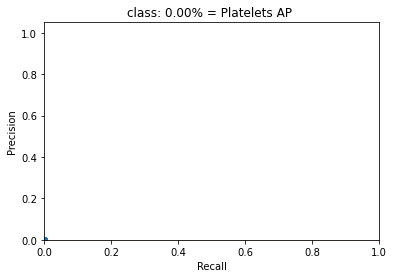

fp  287
tp  685
recall  685
prec  685
12.70% = RBC AP 


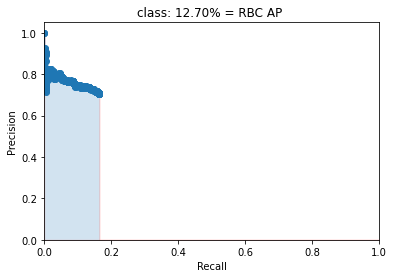

fp  589
tp  133
recall  133
prec  133
16.03% = WBC AP 


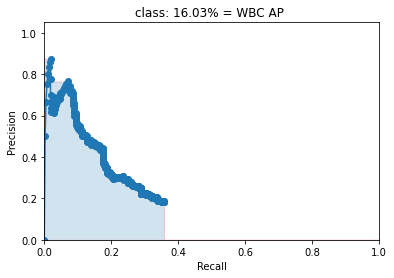

mAP = 9.58%
[('Platelets', 361), ('WBC', 372), ('RBC', 4155)]


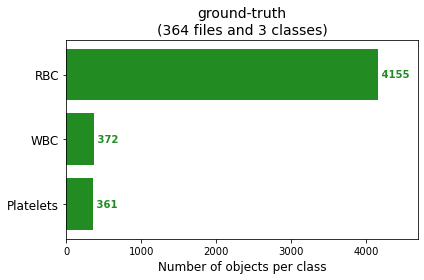

[('Platelets', 89), ('WBC', 722), ('RBC', 972)]


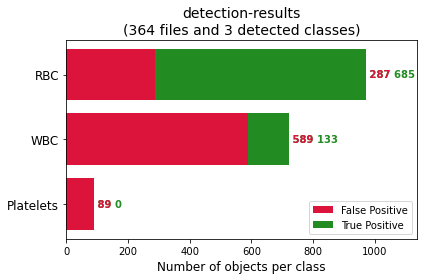

[('Platelets', 0.0), ('RBC', 0.12702319373521326), ('WBC', 0.16025559227773573)]


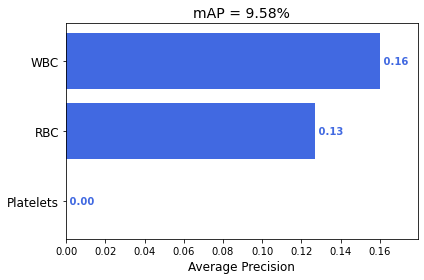

In [100]:
model.eval_map(gt_folder_path = os.path.join(PROJ_PATH, 'eval/ground_truth'), 
               pred_folder_path= os.path.join(PROJ_PATH, 'eval/pred_result'), 
               temp_json_folder_path= os.path.join(PROJ_PATH, 'eval/json'),
              output_files_path=os.path.join(PROJ_PATH, 'eval/result'))

In [81]:
glob(os.path.join(PROJ_PATH, 'eval/pred_result', '*.txt'))

['./eval/pred_result/BloodImage_00015.txt',
 './eval/pred_result/BloodImage_00001.txt',
 './eval/pred_result/BloodImage_00029.txt',
 './eval/pred_result/BloodImage_00217.txt',
 './eval/pred_result/BloodImage_00203.txt',
 './eval/pred_result/BloodImage_00405.txt',
 './eval/pred_result/BloodImage_00377.txt',
 './eval/pred_result/BloodImage_00388.txt',
 './eval/pred_result/BloodImage_00161.txt',
 './eval/pred_result/BloodImage_00175.txt',
 './eval/pred_result/BloodImage_00149.txt',
 './eval/pred_result/BloodImage_00148.txt',
 './eval/pred_result/BloodImage_00174.txt',
 './eval/pred_result/BloodImage_00160.txt',
 './eval/pred_result/BloodImage_00389.txt',
 './eval/pred_result/BloodImage_00410.txt',
 './eval/pred_result/BloodImage_00376.txt',
 './eval/pred_result/BloodImage_00362.txt',
 './eval/pred_result/BloodImage_00404.txt',
 './eval/pred_result/BloodImage_00202.txt',
 './eval/pred_result/BloodImage_00216.txt',
 './eval/pred_result/BloodImage_00028.txt',
 './eval/pred_result/BloodImage_